### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA

plt.style.use("seaborn-v0_8-colorblind")
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings(
    "ignore",
    message="Non-invertible starting MA parameters found.*",
    category=UserWarning,
)
warnings.filterwarnings(
    "ignore",
    message="Non-stationary starting autoregressive parameters.*",
    category=UserWarning,
)
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    module=r"statsmodels\.tsa\.statespace\.sarimax"
)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Paths & column names
CSV_PATH = "../original_data/clean_data.csv"
TIME_COL  = "datetime"
PRICE_COL = "day_ahead_price_eur"

### Load Data & index

In [2]:
df = pd.read_csv(CSV_PATH)
df[TIME_COL] = pd.to_datetime(df[TIME_COL], utc=True)
df = df.set_index(TIME_COL).sort_index()

print(f"Rows: {len(df):,}  |  Range: {df.index.min()} to {df.index.max()}")

Rows: 21,456  |  Range: 2022-01-01 00:00:00+00:00 to 2024-06-12 23:00:00+00:00


### Resampling & Summary Tables

In [3]:
price_hourly    = df[PRICE_COL].resample("h").mean()
price_daily     = df[PRICE_COL].resample("D").mean()
price_weekly    = df[PRICE_COL].resample("W-MON", label="left", closed="left").mean()
price_monthly   = df[PRICE_COL].resample("MS").mean()
price_quarterly = df[PRICE_COL].resample("QS-JAN").mean()

yearly_stats    = price_daily.resample("YE").agg(["mean","std","min","max"]).round(2)
quarterly_stats = price_daily.resample("QE").agg(["mean","std","min","max"]).round(2)
monthly_stats   = price_daily.resample("ME").agg(["mean","std","min","max"]).round(2)

print("Yearly stats (daily averages):")
display(yearly_stats)
print("\nQuarterly stats (daily averages):")
display(quarterly_stats)
print("\nMonthly stats (daily averages):")
display(monthly_stats)

# Save tables
yearly_stats.to_csv("yearly_stats_daily_avg.csv")
quarterly_stats.to_csv("quarterly_stats_daily_avg.csv")
monthly_stats.to_csv("monthly_stats_daily_avg.csv")


Yearly stats (daily averages):


,mean,std,min,max
datetime,,,,
2022-12-31 00:00:00+00:00,166.71,60.52,61.08,388.42
2023-12-31 00:00:00+00:00,111.66,29.75,1.18,186.46
2024-12-31 00:00:00+00:00,83.86,18.58,25.50,124.75



Quarterly stats (daily averages):


,mean,std,min,max
datetime,,,,
2022-03-31 00:00:00+00:00,134.62,35.77,73.66,251.70
2022-06-30 00:00:00+00:00,149.96,41.73,61.08,283.86
2022-09-30 00:00:00+00:00,221.99,72.52,102.34,388.42
2022-12-31 00:00:00+00:00,159.42,44.43,62.49,246.00
2023-03-31 00:00:00+00:00,129.73,26.59,48.30,186.46
2023-06-30 00:00:00+00:00,115.23,23.15,48.66,169.42
2023-09-30 00:00:00+00:00,110.88,20.98,43.54,144.95
2023-12-31 00:00:00+00:00,91.22,33.47,1.18,151.58
2024-03-31 00:00:00+00:00,81.73,16.65,33.89,123.43



Monthly stats (daily averages):


,mean,std,min,max
datetime,,,,
2022-01-31 00:00:00+00:00,143.99,47.67,73.66,251.70
2022-02-28 00:00:00+00:00,116.81,23.69,83.59,180.74
2022-03-31 00:00:00+00:00,141.33,24.19,85.91,189.31
2022-04-30 00:00:00+00:00,124.27,29.53,61.08,186.83
2022-05-31 00:00:00+00:00,140.64,26.34,101.86,189.63
2022-06-30 00:00:00+00:00,185.27,41.81,117.40,283.86
2022-07-31 00:00:00+00:00,220.08,61.03,102.34,331.52
2022-08-31 00:00:00+00:00,268.88,77.45,147.08,388.42
2022-09-30 00:00:00+00:00,175.50,43.08,103.16,313.24


### Plot — Hourly

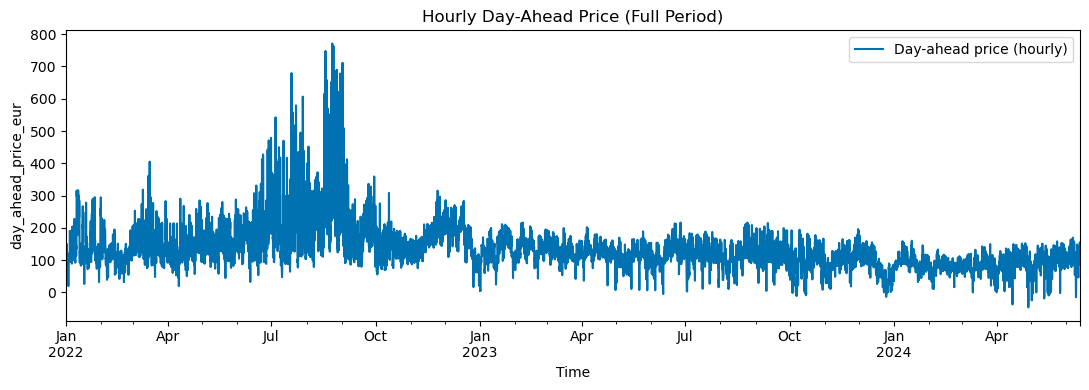

In [4]:
plt.figure(figsize=(11,4))
df[PRICE_COL].plot(label="Day-ahead price (hourly)")
plt.title("Hourly Day-Ahead Price (Full Period)")
plt.xlabel("Time"); plt.ylabel(PRICE_COL); plt.legend()
plt.tight_layout()
plt.savefig("plot_hourly_full_period.png", dpi=200, bbox_inches="tight")
plt.show()

### Plot — Daily Average & Rolling Means

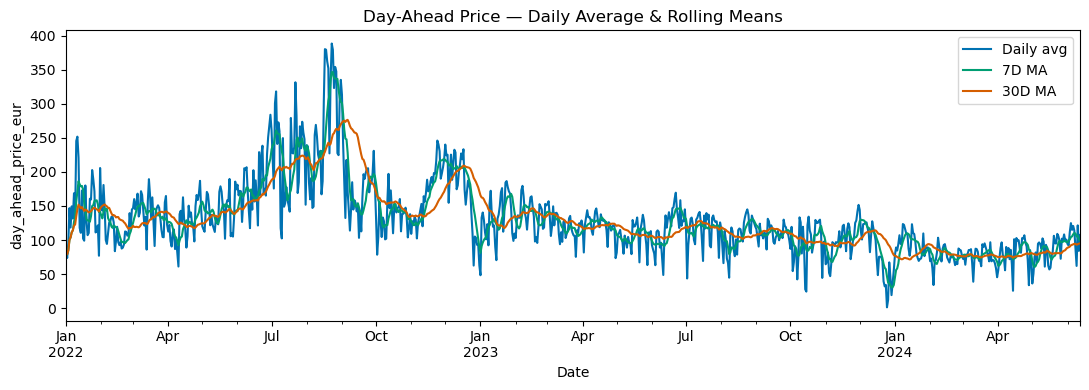

In [5]:
roll7  = price_daily.rolling(7,  min_periods=1).mean()
roll30 = price_daily.rolling(30, min_periods=1).mean()

plt.figure(figsize=(11,4))
price_daily.plot(label="Daily avg")
roll7.plot(label="7D MA")
roll30.plot(label="30D MA")
plt.title("Day-Ahead Price — Daily Average & Rolling Means")
plt.xlabel("Date"); plt.ylabel(PRICE_COL); plt.legend()
plt.tight_layout()
plt.savefig("plot_daily_avg_with_rollings.png", dpi=200, bbox_inches="tight")
plt.show()


### Seasonality

#### Intraday Profile

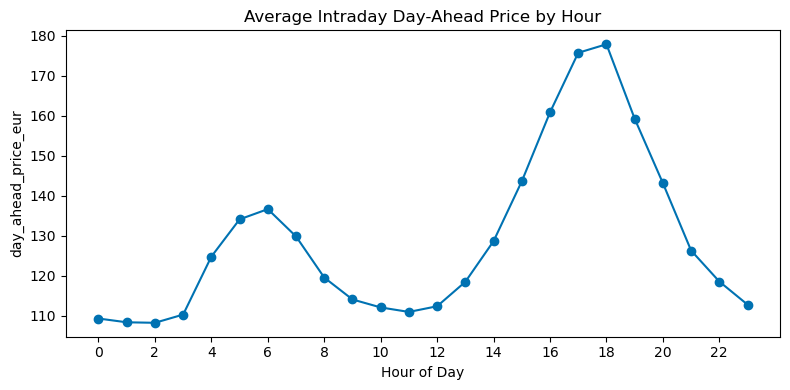

In [6]:
intraday = df[PRICE_COL].groupby(df.index.hour).mean()

plt.figure(figsize=(8,4))
plt.plot(intraday.index, intraday.values, marker="o")
plt.title("Average Intraday Day-Ahead Price by Hour")
plt.xlabel("Hour of Day"); plt.ylabel(PRICE_COL)
plt.xticks(range(0,24,2))
plt.tight_layout()
plt.savefig("plot_intraday_by_hour.png", dpi=200, bbox_inches="tight")
plt.show()

# Save table
intraday.to_csv("intraday_hourly_mean.csv", header=[PRICE_COL])

#### Month of Year

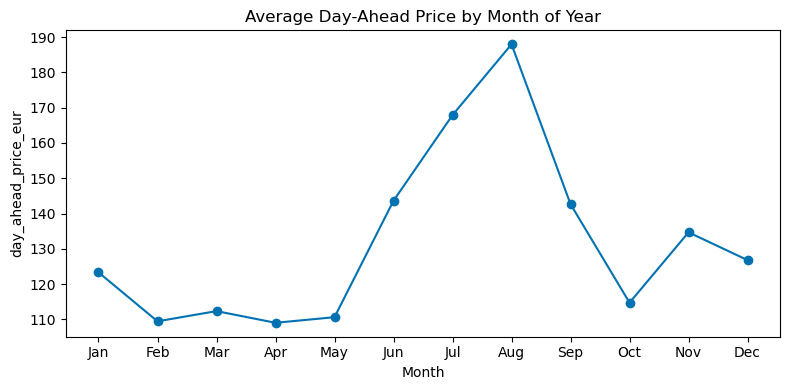

In [7]:
month_avg   = df[PRICE_COL].groupby(df.index.month).mean()
month_names = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

plt.figure(figsize=(8,4))
plt.plot(range(1, len(month_avg)+1), month_avg.values, marker="o")
plt.title("Average Day-Ahead Price by Month of Year")
plt.xlabel("Month"); plt.ylabel(PRICE_COL)
plt.xticks(range(1, len(month_avg)+1), month_names[:len(month_avg)])
plt.tight_layout()
plt.savefig("plot_month_of_year_avg.png", dpi=200, bbox_inches="tight")
plt.show()

# Save table
month_avg.to_csv("month_of_year_avg.csv", header=[PRICE_COL])

#### Day of Week

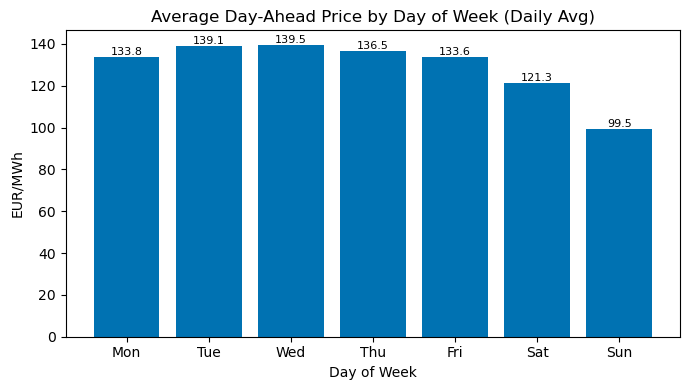

In [8]:
dow_avg   = price_daily.groupby(price_daily.index.dayofweek).mean()
dow_names = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]

plt.figure(figsize=(7,4))
plt.bar(dow_names, dow_avg.values)
plt.title("Average Day-Ahead Price by Day of Week (Daily Avg)")
plt.xlabel("Day of Week")
plt.ylabel("EUR/MWh")

# Optional: label bars
for i, v in enumerate(dow_avg.values):
    if not np.isnan(v):
        plt.text(i, v, f"{v:.1f}", ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.savefig("plot_dow_daily_avg.png", dpi=200, bbox_inches="tight")
plt.show()

# Save table (will include NaN if some weekdays were missing)
dow_avg.to_csv("day_of_week_avg.csv", header=["EUR/MWh"])

## Helper — STL Metrics

In [9]:
def stl_quick_metrics(s: pd.Series, freq: str, period: int):
    s = s.asfreq(freq).interpolate("time")
    res = STL(s, period=period, robust=True).fit()
    T, S, R = res.trend, res.seasonal, res.resid
    y_mean = float(s.mean())

    # Trend slope (% per year) from STL trend
    t_years = (s.index - s.index[0]).days / 365.25
    slope_year = np.polyfit(t_years, T.values, 1)[0]
    slope_pct_year = float(100 * slope_year / y_mean) if y_mean != 0 else np.nan

    # Seasonality strength (Hyndman)
    season_strength = float(max(0.0, 1.0 - (np.var(R) / np.var(S + R))))

    # Seasonal amplitude (% of mean)
    idx = np.arange(len(S)) % period
    prof = pd.Series(S.values, index=idx).groupby(level=0).mean()
    season_amp_pct = float(100 * (prof.max() - prof.min()) / y_mean) if y_mean != 0 else np.nan

    return {
        "mean": y_mean,
        "trend_slope_%/yr": slope_pct_year,
        "season_strength": season_strength,
        "season_amp_%": season_amp_pct,
    }

### STL — Daily

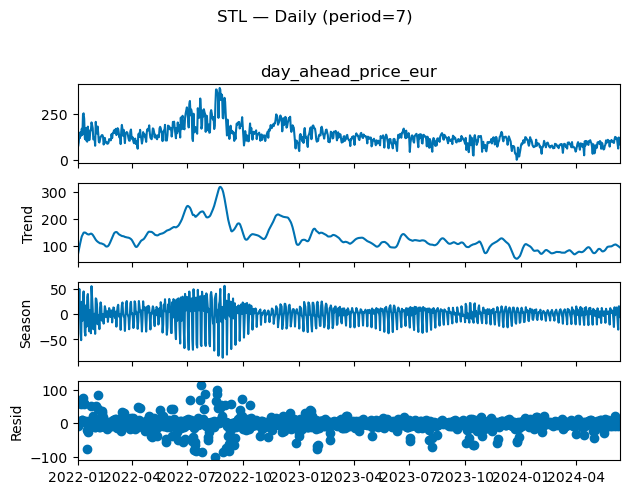

In [10]:
s = price_daily.asfreq("D").interpolate("time")
res = STL(s, period=7, robust=True).fit()
fig = res.plot()
fig.suptitle("STL — Daily (period=7)", y=1.02)
plt.tight_layout()
fig.savefig("stl_daily_period7.png", dpi=200, bbox_inches="tight")
plt.show()


### STL Weekly

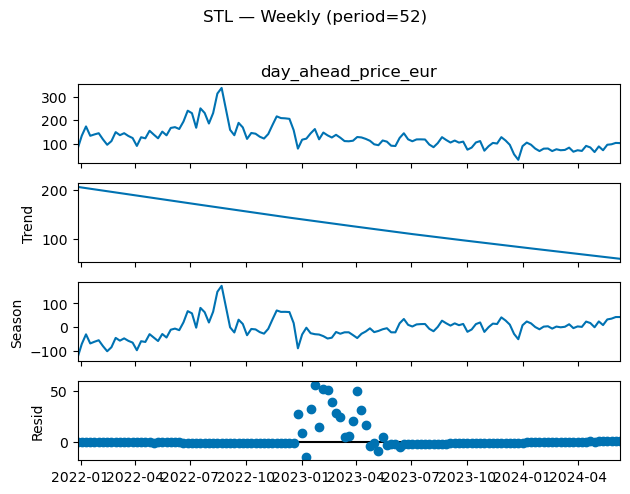

In [11]:
s = price_weekly.asfreq("W-MON").interpolate("time")
res = STL(s, period=52, robust=True).fit()
fig = res.plot()
fig.suptitle("STL — Weekly (period=52)", y=1.02)
plt.tight_layout()
fig.savefig("stl_weekly_period52.png", dpi=200, bbox_inches="tight")
plt.show()


### STL Monthly

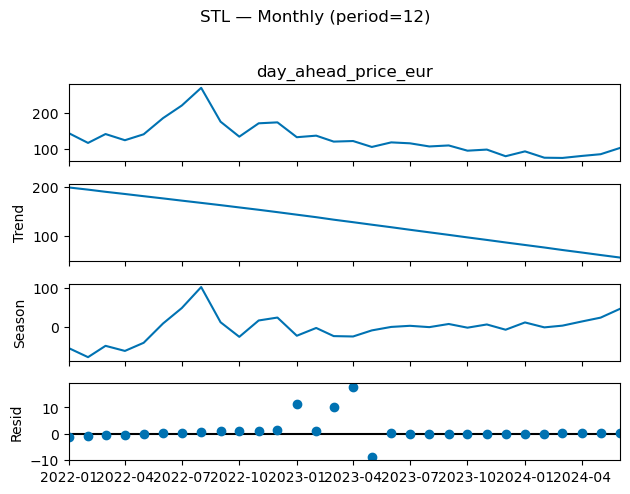

In [12]:
s = price_monthly.asfreq("MS").interpolate("time")
res = STL(s, period=12, robust=True).fit()
fig = res.plot()
fig.suptitle("STL — Monthly (period=12)", y=1.02)
plt.tight_layout()
fig.savefig("stl_monthly_period12.png", dpi=200, bbox_inches="tight")
plt.show()


### STL — Quarterly

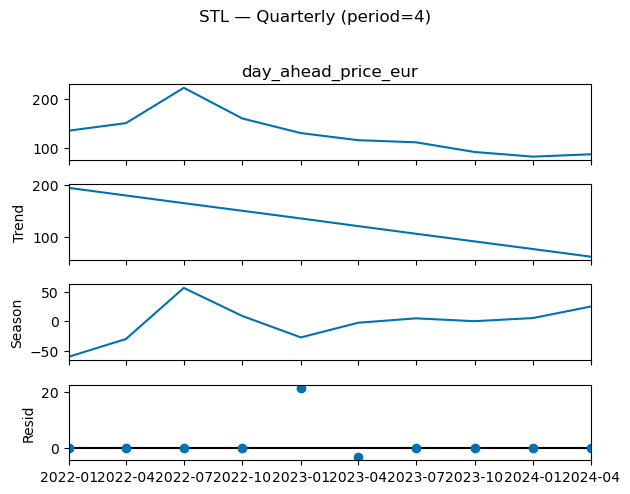

In [13]:
s = price_quarterly.asfreq("QS-JAN").interpolate("time")
res = STL(s, period=4, robust=True).fit()
fig = res.plot()
fig.suptitle("STL — Quarterly (period=4)", y=1.02)
plt.tight_layout()
fig.savefig("stl_quarterly_period4.png", dpi=200, bbox_inches="tight")
plt.show()

###  STL Metrics Table

In [14]:
records = []
records.append({"series":"daily",     **stl_quick_metrics(price_daily,     "D",      7) })
records.append({"series":"weekly",    **stl_quick_metrics(price_weekly,    "W-MON", 52) })
records.append({"series":"monthly",   **stl_quick_metrics(price_monthly,   "MS",    12) })
records.append({"series":"quarterly", **stl_quick_metrics(price_quarterly, "QS-JAN", 4) })

stl_df = pd.DataFrame(records).set_index("series")
print("=== STL quick metrics ===")
display(stl_df.round(1))

# Save table
stl_df.round(1).to_csv("stl_quick_metrics.csv")


=== STL quick metrics ===


,mean,trend_slope_%/yr,season_strength,season_amp_%
series,,,,
daily,129.0,-30.6,0.4,31.3
weekly,128.7,-46.4,0.9,147.1
monthly,128.4,-46.2,1.0,59.9
quarterly,128.1,-46.3,0.9,45.5


### Helpers — ARIMA Utilities

In [15]:
def error_metrics(y, yhat):
    y = pd.Series(y, dtype="float64")
    yhat = pd.Series(yhat, dtype="float64").reindex_like(y)
    e = (y - yhat).dropna()
    rmse = float(np.sqrt(np.mean(e**2)))
    mae  = float(np.mean(np.abs(e)))
    denom = np.maximum(np.abs(y.loc[e.index]), 1e-6)  # safe MAPE
    mape = float(np.mean(np.abs(e)/denom) * 100.0)
    return rmse, mae, mape

def holdout_train_test(s, test_frac=0.2, min_test=30):
    s = s.dropna().astype(float)
    n = len(s)
    test_size = max(int(n*test_frac), min_test)
    if n <= test_size + 10:
        return s, None
    return s.iloc[:-test_size], s.iloc[-test_size:]

def fit_arima_auto_pmdarima(s):
    import pmdarima as pm
    s = s.dropna().astype(float)
    model = pm.auto_arima(
        s, seasonal=False, stepwise=True, suppress_warnings=True,
        error_action="ignore", max_p=3, max_q=3, max_d=2, information_criterion="aic"
    )
    yhat_in = pd.Series(model.predict_in_sample(), index=s.index)
    resid   = s - yhat_in

    var_y   = float(np.var(s))
    r2_like = float(1 - np.var(resid)/var_y) if var_y > 0 else np.nan
    in_rmse, in_mae, in_mape = error_metrics(s, yhat_in)

    train, test = holdout_train_test(s)
    oos_rmse=oos_mae=oos_mape=np.nan
    if test is not None:
        m_tr = pm.auto_arima(
            train, seasonal=False, stepwise=True, suppress_warnings=True,
            error_action="ignore", max_p=3, max_q=3, max_d=2, information_criterion="aic"
        )
        fc = pd.Series(m_tr.predict(n_periods=len(test)), index=test.index)
        oos_rmse, oos_mae, oos_mape = error_metrics(test, fc)

    return {
        "order": str(model.order),
        "aic": float(model.aic()), "bic": float(model.bic()),
        "in_rmse": in_rmse, "in_mae": in_mae, "in_mape_%": in_mape,
        "r2_like": r2_like,
        "oos_rmse": oos_rmse, "oos_mae": oos_mae, "oos_mape_%": oos_mape,
    }

def fit_arima_tiny_grid(s):
    s = s.dropna().astype(float)
    best = {"aic": np.inf, "res": None, "order": None}
    for d in (0,1):
        for p in (0,1,2):
            for q in (0,1,2):
                try:
                    res = ARIMA(s, order=(p,d,q)).fit()
                    aic = float(res.aic)
                    if aic < best["aic"]:
                        best = {"aic": aic, "res": res, "order": (p,d,q)}
                except Exception:
                    continue
    res = best["res"]; order = best["order"]
    fitted = res.fittedvalues.reindex(s.index)
    resid  = (s - fitted).dropna()

    var_y   = float(np.var(s.loc[resid.index]))
    r2_like = float(1 - np.var(resid)/var_y) if var_y > 0 else np.nan
    in_rmse, in_mae, in_mape = error_metrics(s.loc[resid.index], fitted.loc[resid.index])

    train, test = holdout_train_test(s)
    oos_rmse=oos_mae=oos_mape=np.nan
    if test is not None:
        res_tr = ARIMA(train, order=order).fit()
        fc = res_tr.forecast(steps=len(test))
        oos_rmse, oos_mae, oos_mape = error_metrics(test, fc)

    return {
        "order": str(order),
        "aic": float(res.aic), "bic": float(res.bic),
        "in_rmse": in_rmse, "in_mae": in_mae, "in_mape_%": in_mape,
        "r2_like": r2_like,
        "oos_rmse": oos_rmse, "oos_mae": oos_mae, "oos_mape_%": oos_mape,
    }

def fit_arima_auto_metrics(s):
    try:
        return fit_arima_auto_pmdarima(s)
    except Exception:
        return fit_arima_tiny_grid(s)


### ARIMA — Metrics Across Frequencies

In [16]:
series_info = [
    ("hourly",    price_hourly),
    ("daily",     price_daily),
    ("weekly",    price_weekly),
    ("monthly",   price_monthly),
    ("quarterly", price_quarterly),
]

rows = []
for name, s in series_info:
    rows.append({"series": name, **fit_arima_auto_metrics(s)})

arima_df = pd.DataFrame(rows).set_index("series")
print("=== ARIMA (auto) metrics ===")
display(arima_df.round(1))

# Save table
arima_df.round(1).to_csv("arima_auto_metrics.csv")

=== ARIMA (auto) metrics ===


,order,aic,bic,in_rmse,in_mae,in_mape_%,r2_like,oos_rmse,oos_mae,oos_mape_%
series,,,,,,,,,,
hourly,"(2, 1, 2)",186358.8,186398.7,18.6,10.8,205030.0,0.9,35.5,29.3,7059881.0
daily,"(0, 1, 2)",8481.9,8496.3,28.0,20.2,22.1,0.7,21.8,16.4,67.8
weekly,"(0, 1, 2)",1198.9,1207.5,26.5,19.4,16.1,0.7,21.6,17.1,25.4
monthly,"(0, 1, 0)",278.1,279.5,38.2,24.4,17.6,0.2,NaN,NaN,NaN
quarterly,"(0, 1, 0)",91.5,91.7,53.9,36.7,26.0,-0.8,NaN,NaN,NaN


### Hourly ARIMA Forecast

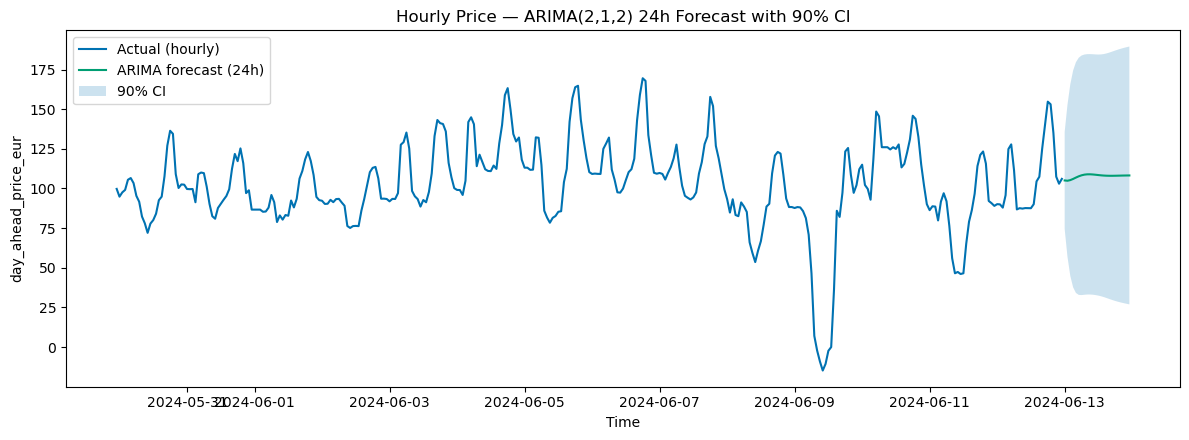

In [17]:
HISTORY_DAYS   = 14
FORECAST_HOURS = 24
ALPHA          = 0.1

s_hourly = df[PRICE_COL].asfreq("h").interpolate("time")
y = s_hourly.dropna().astype(float)

res = ARIMA(y, order=(2,1,2)).fit()
pred = res.get_forecast(steps=FORECAST_HOURS)
fc_mean = pred.predicted_mean
ci      = pred.conf_int(alpha=ALPHA)
ci_low, ci_high = ci.iloc[:,0], ci.iloc[:,1]
used = "ARIMA(2,1,2)"
hist = s_hourly.loc[s_hourly.index.max() - pd.Timedelta(days=HISTORY_DAYS):]

plt.figure(figsize=(12,4.5))
plt.plot(hist.index, hist.values, label="Actual (hourly)")
plt.plot(fc_mean.index, fc_mean.values, label=f"ARIMA forecast ({FORECAST_HOURS}h)")
plt.fill_between(fc_mean.index, ci_low.values, ci_high.values, alpha=0.2, label=f"{int((1-ALPHA)*100)}% CI")
plt.title(f"Hourly Price — {used} {FORECAST_HOURS}h Forecast with {int((1-ALPHA)*100)}% CI")
plt.xlabel("Time"); plt.ylabel(PRICE_COL); plt.legend()
plt.tight_layout()
plt.savefig("plot_arima_hourly_forecast.png", dpi=200, bbox_inches="tight")
plt.show()